# Homework 1: Web Scrapping
# By Alon Galperin
## scrapping Wikipedia

<b>
    <p>
        <h3>Introduction</h3>
        In this exercise we will scrape Wikipedia website and gather information about movie stars. <br />
        I choose to do the exercise around the actresses Natalie Portman.   
    <p/>
    <p>
        <h3>Assignment structure</h3>
        At first we have 3 oop classes and after that we have the code for running methods from the classes and <br />
        answering the quetions.
        I preferred to work in object oriented approach, so I wrote 3 classes that helped me orgenize the data in the program.
        <br /> <br />
        The classes are: <br />
        <u>Wiki_Parser</u>: class for managing the access and data scraping from Wikipedia and re-parse the tables that was fetched. <br />
        <u>Actor</u>: class for representing the actors in our system. <br />
        Actor will have the following data saved in it:
        <ul>
            <li>Name</li>
            <li>Url to wikipedia page</li>
            <li>Birth date</li>
            <li>Birth country</li>
            <li>List of movies he/she participated in</li>
            <li>list of actors played along them - the list called coactors</li>
        </ul>
        <u>Movie</u>: class same as actor but for movies in our system. <br />
        Movie will have the following data saved in it:
        <ul>
            <li>Name</li>
            <li>Url to wikipedia page</li>
            <li>List of movies he/she participated in</li>
            <li>list of actors playing in this movie</li>
        </ul>
    <p/>
<b />

In [1]:
# import the library used to query a website
import urllib2

# import the Beautiful soup functions to parse the data returned from the website
from bs4 import BeautifulSoup

# for using regex
import re

# import pandas for dataframes
import pandas as pd

# import numpy for Wiki_Parser internal usage
import numpy as np

# nltk for stop words of english language. used in Actor -> get_movie_link
from nltk.corpus import stopwords

In [2]:
# class for managing the access and data scraping from Wikipedia and re-parse the tables that was fetched. 
class Wiki_Parser:
    def pre_process_table(self, table):
        """
        INPUT:
            1. table - a bs4 element that contains the desired table: ie <table> ... </table>
        OUTPUT:
            a tuple of: 
                1. rows - a list of table rows ie: list of <tr>...</tr> elements
                2. num_rows - number of rows in the table
                3. num_cols - number of columns in the table
        Options:
            include_td_head_count - whether to use only th or th and td to count number of columns (default: False)
        """
        rows = [x for x in table.find_all('tr')]

        num_rows = len(rows)

        # get an initial column count. Most often, this will be accurate
        num_cols = max([len(x.find_all(['th','td'])) for x in rows])

        # sometimes, the tables also contain multi-colspan headers. This accounts for that:
        header_rows_set = [x.find_all(['th', 'td']) for x in rows if len(x.find_all(['th', 'td']))>num_cols/2]

        num_cols_set = []

        for header_rows in header_rows_set:
            num_cols = 0
            for cell in header_rows:
                row_span, col_span = self.get_spans(cell)
                num_cols+=len([cell.getText()]*col_span)

            num_cols_set.append(num_cols)

        num_cols = max(num_cols_set)

        return (rows, num_rows, num_cols)


    def get_spans(self, cell):
            """
            INPUT:
                1. cell - a <td>...</td> or <th>...</th> element that contains a table cell entry
            OUTPUT:
                1. a tuple with the cell's row and col spans
            """
            if cell.has_attr('rowspan'):
                rep_row = int(cell.attrs['rowspan'])
            else: # ~cell.has_attr('rowspan'):
                rep_row = 1
            if cell.has_attr('colspan'):
                rep_col = int(cell.attrs['colspan'])
            else: # ~cell.has_attr('colspan'):
                rep_col = 1 

            return (rep_row, rep_col)

    def process_rows(self, rows, num_rows, num_cols):
        """
        INPUT:
            1. rows - a list of table rows ie <tr>...</tr> elements
        OUTPUT:
            1. data - a Pandas dataframe with the html data in it
        """
        data = pd.DataFrame(np.ones((num_rows, num_cols))*np.nan)
        for i, row in enumerate(rows):
            try:
                col_stat = data.iloc[i,:][data.iloc[i,:].isnull()].index[0]
            except IndexError:
                print(i, row)

            for j, cell in enumerate(row.find_all(['td', 'th'])):
                rep_row, rep_col = self.get_spans(cell)

                #find first non-na col and fill that one
                while any(data.iloc[i,col_stat:col_stat+rep_col].notnull()):
                    col_stat+=1

                data.iloc[i:i+rep_row,col_stat:col_stat+rep_col] = cell.getText()
                if col_stat<data.shape[1]-1:
                    col_stat+=rep_col

        return data
    
    def get_table_by_class(self, class_name):
        return 0

    def get_element_by_header(self, url ,header_text, element):
        next_tag = ""
        page = urllib2.urlopen(url)
        soup = BeautifulSoup(page, "lxml")
        spans = soup.find_all('span', attrs = {'class' : 'mw-headline'})
        for span in spans:
            text = span.get_text().lower()
            if header_text in text:
                parent = span.parent
                next_tag = parent.findNext(element)
                return next_tag
        return None # element not found
    
    def get_list_by_text(self, text):
        __
    
    def get_movie_titles_index(self, table):
        rows = table.find_all("tr")
        table_headers = rows[0].find_all('th') # get the headsers of the table

        index_for_movie_name = 0
        for header in table_headers: # iterate on the headers
            header_text = header.text
            if header_text.find('Title') != -1 or header_text.find('Film') != -1: # search in string
                break
            else:
                index_for_movie_name += 1
        return index_for_movie_name
    
    # finds link to movie from filmography table
    def get_movie_link(self, movie, table):
        try:
            words_from_name = movie.split(' ')
        except:
            return None
        
        good_words = []
        stop = set(stopwords.words('english'))
        for word in words_from_name:
            if word.lower() not in stop:
                good_words.append(word)

        word_to_search = ""
        if len(good_words) == 0: # we have no good words to search
            return
        elif len(good_words) >= 3:
            word_to_search = good_words[-1] # take the last word
        else:
            word_to_search =  good_words[0] #take the first worf from the name for better search
        
        try:
            return table.find('a', text = re.compile(word_to_search))
        except:
            return None
        
    def print_dict(self, dict, columns_names):
        df = pd.DataFrame(list(dict.iteritems()),
                      columns=columns_names)
        df.set_index(columns_names[0], inplace=True)
        display(df)

#### Parser as global variable, used in Movie and Actor classes

In [3]:
wiki_parser = Wiki_Parser()

<h1> Actor class </h1>

In [4]:
class Actor:
    def __init__(self, _name):
        try:
            _name = str(_name)
        except:
            _name = _name.encode('utf-8')
        self.name = _name.strip()
        self.movies_participated = set()
        self.coactors = set()
        self.url = "https://en.wikipedia.org/wiki/" + self.get_underscore_name()
    
    def get_name(self):
        return self.name

    def get_underscore_name(self):
        return self.name.replace(" ", "_")
    
    def add_movie(self, movie_name, movie_url):
        movie = Movie(movie_name, movie_url)
        self.movies_participated.add(movie)
      
    def set_birth_year_country(self):
        try:
            pageActor = urllib2.urlopen(self.get_url())
        except:
            self.birth_year = "data not available"
            self.birth_country = "data not available"
            return
        
        soup = BeautifulSoup(pageActor, "lxml")
        details_table = soup.findAll('table', {"class" : "infobox"}) # write infobox and not biagrophy for more generic code
        if len(details_table) > 0: # we found summary table
            details_table = details_table[0]
            for row in details_table.findAll("tr"):
                header = row.findAll('th')
                data = row.find('td')
                ## set the birth year
                if len(header) > 0 and header[0].text == 'Born':
                    birth_text = data.text
                    try:
                        self.birth_year = re.search(r'[12]\d{3}', birth_text).group(0)
                    except:
                        self.birth_year = "data not available"
                        
                    # set the birth country
                    try:
                        conutries = re.split(', |\n',birth_text)
                        self.birth_country = conutries[-1]
                    except:
                        self.birth_country = "data not available"
                else: # no born field in infobox
                    self.birth_country = "data not available"
                    self.birth_year = "data not available"
        else:
            self.birth_year = "data not available"
            self.birth_country = "data not available"
            return
    
    def get_filmography_link(self):
        return 'https://en.wikipedia.org/wiki/' + self.name.replace(" ", "_") + '_filmography'
    
    def get_url(self):
        return self.url
    
    def get_birth_year(self):
        return self.birth_year
    
    def get_birth_country(self):
        return self.birth_country

    def add_coactor(self, coactor):
        self.coactors.add(coactor)
    
    def set_movies(self):
        page_for_movies = self.get_filmography_link()
        try: # try to see if there is filmgraphy page
            page = urllib2.urlopen(page_for_movies)
        except: # no filmography page found
            page_for_movies = self.get_url()
        
        try:
            table = wiki_parser.get_element_by_header(page_for_movies, 'film', 'table')
        except:
            return
        
        if table is not None: # we have a filmography table
            rows, num_rows, num_cols = wiki_parser.pre_process_table(table)
            df = wiki_parser.process_rows(rows, num_rows, num_cols)
            index_for_movie_name = wiki_parser.get_movie_titles_index(table)

            df.drop(df.index[[0]] , inplace=True) # delete the header
            
            try:
                for movie in df[index_for_movie_name]:
                    movie_link = wiki_parser.get_movie_link(movie, table)

                    if movie_link is not None:
                        self.movies_participated.add(Movie(movie, movie_link['href']))
                    else:
                        self.movies_participated.add(Movie(movie, ""))
            except:
                return
                
        else: # we didnt find table of films in filmography page
            return 
                
    def get_movies(self):
        return self.movies_participated
    
    def set_coactors_limit(self, _limit):
        self_movies = self.get_movies()
        counter = 0

        for movie in self_movies:
            movie.set_actors()
            actors = movie.get_actors()
            for actor_iterator in actors:
                if actor_iterator.get_name() != self.get_name():
                    if counter == _limit: # we found enough co-actors acording to the limit sent
                        return
                    else:
                        coactor = Actor(actor_iterator.get_name())
                        coactor.set_movies()
                        
                        intersection = len(self_movies & coactor.get_movies())      
                                                
                        if (intersection != 0): # we  want to add noly actors with  data about comoon movies
                            coactor.set_birth_year_country()
                            coactor.set_awards()
                            self.add_coactor(coactor)
                            counter += 1 # we want to limit the number of actors to 50
                            print(str(counter) + ' \ ' + str(_limit) + ' ' + coactor.get_name())
        return
    
    def get_coactors(self):
        return self.coactors;
    
    def set_awards(self):
        url = "https://en.wikipedia.org/wiki/List_of_awards_and_nominations_received_by_" + self.get_name().replace(' ','_')
        try: # try to see if there is filmgraphy page
            page_for_awards = urllib2.urlopen(url)
        except: # no filmography page found
            url = "https://en.wikipedia.org/wiki/" + self.get_underscore_name()
            try:
                page_for_awards = urllib2.urlopen(url)
            except:
                return ('no rewards found')
        soup = BeautifulSoup(page_for_awards, "lxml")
        # wons = soup.find_all('td', attrs={"class" : "yes"})
        wons_to_check = soup.find_all('td')
        
        num_awards = 0
        for win in wons_to_check:
            td_text = win.get_text().lower()
            if ('won' in td_text  or 'honored' in td_text):
                num_awards += + 1
        if num_awards != 0:
            self.num_awards = num_awards
        else:
            self.num_awards = '0 prizes'
        
    def get_num_awards(self):
        return self.num_awards
                
    def print_details_table(self):
        # get table of movies tables and fix the colspan
        try: # try to get movies table from filmography page
            page = urllib2.urlopen(self.get_filmography_link())
            films_table = wiki_parser.get_element_by_header(self.get_filmography_link(), "film", "table" )
        except: # try to get movies table from actor main page
            films_table = wiki_parser.get_element_by_header(self.get_url(), "film", "table" )
            
        # colspan fixing
        rows, num_rows, num_cols = wiki_parser.pre_process_table(films_table)
        df = wiki_parser.process_rows(rows, num_rows, num_cols)
                
        # set the first row to be the index and delete the first row after (). first row = "title, year..."
        df.columns = df.iloc[0]
        df.drop(df.index[[0]] , inplace=True)
        
        #clean the columns names
        df.rename(columns=lambda x: x.replace('(s)', ''), inplace=True)
        
        # reorder the order of columns
        try:
            df = df[['Year', 'Title','Role','Director']]
        except KeyError as e:
            missing_column =  e.message.split('\'')[1]
            df[missing_column] = np.nan
            df = df[['Year', 'Title','Role','Director']]
        
        # sort the data acording to year in ascending order
        df = df.sort_values('Year', ascending=True)

        display(df)
    
    # comperator 
    def __eq__(self, other):
        if isinstance(other, Actor):
            return (self.name == other.name)
        else:
            return False
    # hash function for set datastructure           
    def __hash__(self):
        return hash(self.name)

<h1>Movie class </h1>

In [5]:
# the movie class need the url in the constractor because it not always consist only the name of the movie and underline
# some times it is the name of the movie and (film) concatinated
class Movie:
    def __init__(self, _name, _url):
        self.name = _name
        self.url = "https://en.wikipedia.org" + _url
        self.actors = []
        
    def get_name(self):
        return self.name
    
    def get_url(self):
        return self.url
    
    def set_actors(self):
        actors_list = wiki_parser.get_element_by_header(self.get_url(), "cast", "ul")
        
        if (hasattr(actors_list, 'find_all')): # if paragraph is str - so that means no cast found
            li_s = actors_list.find_all("li")
            for li in li_s:
                li_text = li.get_text()
                actor_name = li_text.split('as')[0]
                self.actors.append(Actor(actor_name))
    
    def get_actors(self):
        return self.actors
    
    def __eq__(self, other):
        if isinstance(other, Movie):
            return (self.name == other.get_name())
        else:
            return False
                    
    def __hash__(self):
        return hash(self.get_name())

<h1>Answers</h1>

<h2>Natalie Portman</h2>
<img src="https://i.pinimg.com/236x/6f/d8/2f/6fd82f3e0f6121ec5b22a8705dfc67dd--mathilda-leon-movie-characters.jpg" style="margin-left: 0px"></img>
<p>Wikipedia link:
    <a href="https://en.wikipedia.org/wiki/Natalie_Portman">link</a>
</p>

<h2> Question 1 </h2>
<h3> print movies tables, sorted by Year released ascending </h3>

In [6]:
actor = Actor("Natalie Portman")
actor.print_details_table()

,Year,Title,Role,Director
1,1994,Léon: The Professional,Mathilda,Besson !Luc Besson
2,1995,Developing,Nina,Cohn !Marya Cohn
3,1995,Heat,Lauren,Mann !Michael Mann
4,1996,Beautiful Girls,Marty,Demme !Ted Demme
5,1996,Everyone Says I Love You,Laura,Allen !Woody Allen
6,1996,Mars Attacks!,Dale !Taffy Dale,Burton !Tim Burton
7,1999,Star Wars: Episode I – The Phantom Menace,Amidala !Padmé Amidala,Lucas !George Lucas
8,1999,Anywhere but Here,August !Ann August,Wang !Wayne Wang
9,2000,Where the Heart Is,Nation !Novalee Nation,Williams !Matt Williams
10,2001,Zoolander,Herself,Stiller !Ben Stiller


<h2>Question 2</h2>
<p>
    In this question we will limit the number of co actors  that we will retrieve for the actor. <br />
    The variable limit will store the limit number
</p>

In [7]:
limit = 60
actor.set_movies()
actor.set_coactors_limit(limit)

names = []
birth_years = []
birth_country = []
num_awards = []

coactors = actor.get_coactors()

for actor_itr in coactors:
    actor_itr.set_birth_year_country()
    actor_itr.set_awards()
    names.append( actor_itr.get_name() )
    birth_years.append( actor_itr.get_birth_year() )
    birth_country.append( actor_itr.get_birth_country() )
    num_awards.append( actor_itr.get_num_awards() )

df=pd.DataFrame()
df['Name'] = names
df['Birth Year'] = birth_years
df['Birth Country'] = birth_country
df['Num of Awards'] = num_awards

display(df)

1 \ 60 Jude Law
2 \ 60 Julia Roberts
3 \ 60 Clive Owen
4 \ 60 Chris Hemsworth
5 \ 60 Tom Hiddleston
6 \ 60 Anthony Hopkins
7 \ 60 Stellan Skarsgård
8 \ 60 Idris Elba
9 \ 60 Christopher Eccleston
10 \ 60 Adewale Akinnuoye-Agbaje
11 \ 60 Kat Dennings
12 \ 60 Ray Stevenson
13 \ 60 Zachary Levi
14 \ 60 Tadanobu Asano
15 \ 60 Jaimie Alexander
16 \ 60 Rene Russo
17 \ 60 Mila Kunis
18 \ 60 Barbara Hershey
19 \ 60 Winona Ryder
20 \ 60 Benjamin Millepied
21 \ 60 Ksenia Solo
22 \ 60 Kristina Anapau
23 \ 60 Janet Montgomery
24 \ 60 Timothy Hutton
25 \ 60 Matt Dillon
26 \ 60 Noah Emmerich
27 \ 60 Michael Rapaport
28 \ 60 Pruitt Taylor Vince
29 \ 60 Alan Alda
30 \ 60 Woody Allen
31 \ 60 Drew Barrymore
32 \ 60 Goldie Hawn
33 \ 60 Gaby Hoffmann
34 \ 60 Edward Norton
35 \ 60 Julia Roberts
36 \ 60 Tim Roth
37 \ 60 David Ogden Stiers
38 \ 60 Edward Hibbert
39 \ 60 Billy Crudup
40 \ 60 Robert Knepper
41 \ 60 Isiah Whitlock
42 \ 60 Christy Carlson Romano
43 \ 60 Norah Jones
44 \ 60 Jude Law
45 \ 60 David 

,Name,Birth Year,Birth Country,Num of Awards
0,David Strathairn,data not available,data not available,0 prizes
1,Drew Barrymore,data not available,data not available,35
2,Norah Jones,data not available,data not available,29
3,Kristina Anapau,data not available,data not available,0 prizes
4,Alan Alda,data not available,data not available,2
5,Winona Ryder,data not available,data not available,11
6,Benjamin Millepied,data not available,data not available,0 prizes
7,Julia Roberts,data not available,data not available,22
8,Christopher Eccleston,data not available,data not available,5
9,Isiah Whitlock,data not available,data not available,1


<h2>Question 3</h2>

the dictionary coactors_counter: <br />
key = number of movies participated togher, <br /> value = number of coactors played this amount of movies together with out actor 

,Number of coactors
Joint Movies,
1,41
2,14
3,2


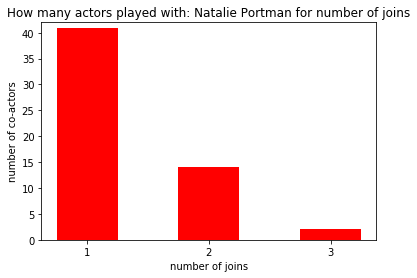

In [8]:
def add_to_counters_dict(counters_dict, counter):
    if counter in counters_dict:
        counters_dict[counter] += 1
    else:
        counters_dict[counter] = 1

coactors_counter = {}
coactors = actor.get_coactors()

for coactor in coactors:
    main_actor_movies = actor.get_movies()
    # we set the movies of each co actor in question 2
    coactor_movies = coactor.get_movies()
    intersection = len(main_actor_movies & coactor.get_movies())
    add_to_counters_dict(coactors_counter, intersection)

# prinint table:

wiki_parser.print_dict(coactors_counter, ['Joint Movies','Number of coactors'])
    
# working with matplotlib to plot the bar plot graph
import matplotlib.pyplot as plt

X = np.arange(len(coactors_counter))
plt.bar(X, coactors_counter.values(), align='center', width=0.5, color=['red'])
plt.xticks(X, coactors_counter.keys())
ymax = max(coactors_counter.values()) + 1
plt.ylim(0, ymax)
plt.title("How many actors played with: " + actor.get_name() + " for number of joins" )
plt.xlabel('number of joins')
plt.ylabel('number of co-actors')

plt.show()